In [2]:
from matplotlib import pyplot
import rasterio
from rasterio.plot import show
import numpy as np
import h3.api.numpy_int as h3
from scipy import ndimage
import geopandas as gpd

# increase the plot size
pyplot.rcParams['figure.dpi'] = 200

(<ColorInterp.red: 3>, <ColorInterp.green: 4>, <ColorInterp.blue: 5>)
(284, 327)


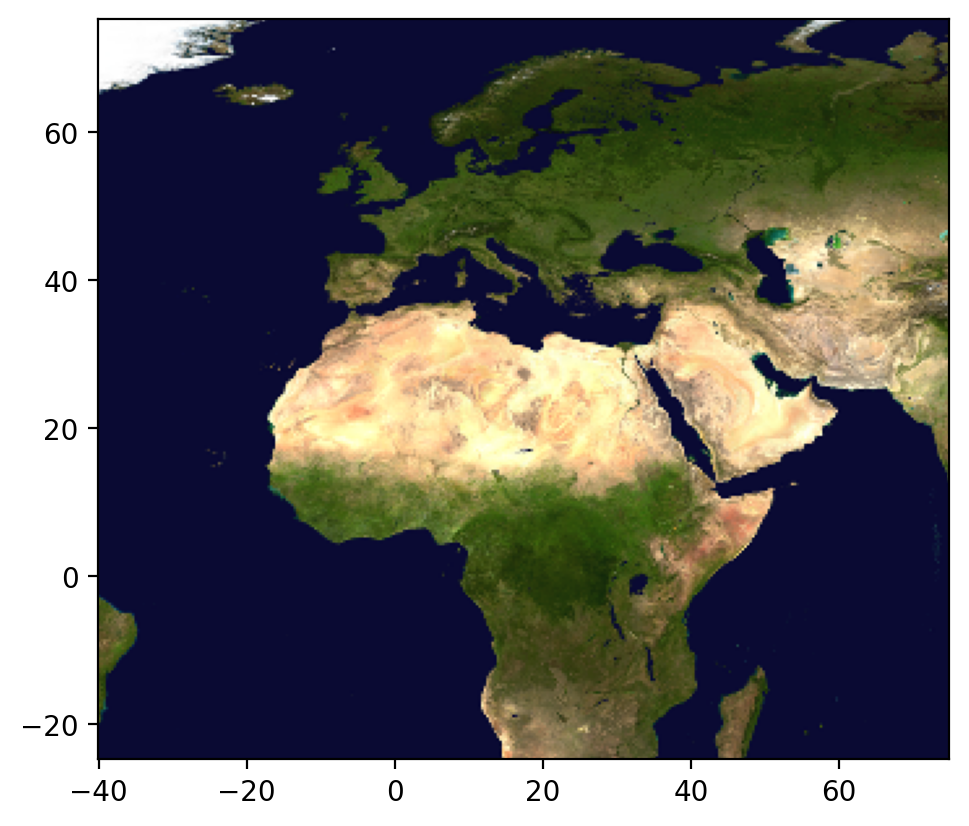

<AxesSubplot:>

In [3]:
src_dir = r'E:\paper\code\h3ronpy\data'
src = rasterio.open(src_dir + "/europe-and-north-africa.tif")
print(src.colorinterp)

green = src.read(2)
blue = src.read(3)
print(green.shape)

show(src)

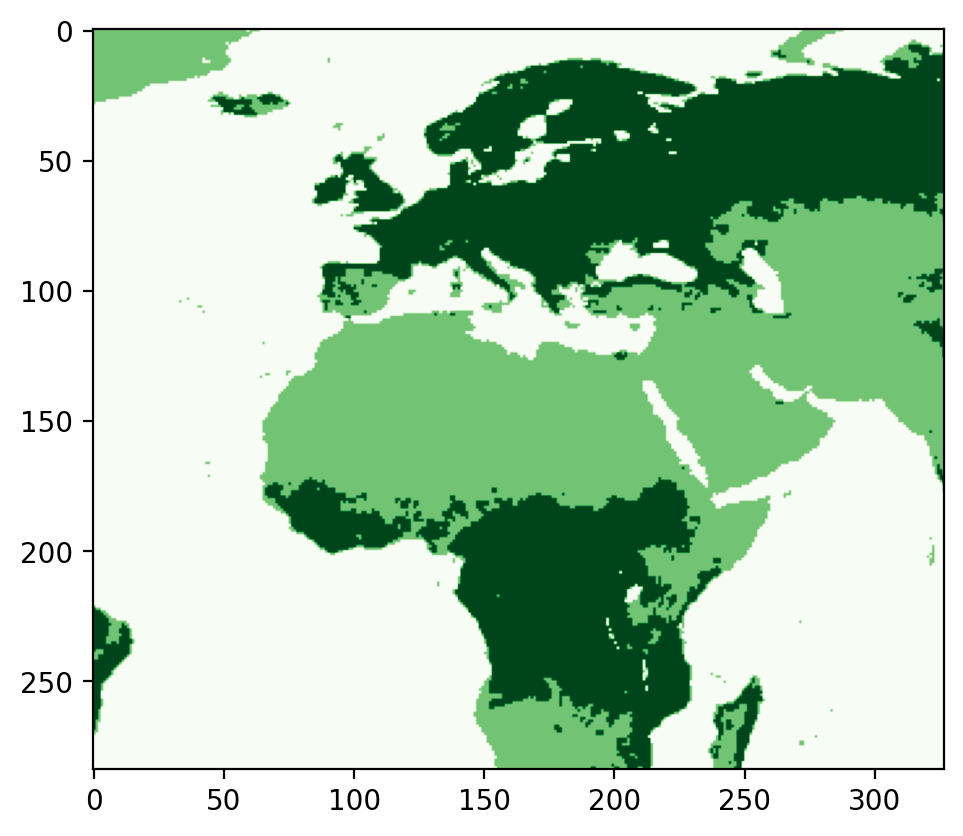

In [4]:
vegetation_mask = (green < 250) & (blue < 50)
ocean_mask = (green >= 6) & (green <= 14) & (blue >= 47) & (blue <= 54)
vegetation_nodata_value = 0

vegetation = np.full(green.shape, 10, dtype="int8")
vegetation[ocean_mask] = vegetation_nodata_value
vegetation[vegetation_mask] = 20
#pyplot.imshow(vegetation, cmap='Greens')

# smooth a bit to remove single pixels
vegetation = ndimage.gaussian_filter(vegetation, sigma=.7)
vegetation[vegetation <= 5] = vegetation_nodata_value
vegetation[(vegetation > 0) & (vegetation < 15)] = 1
vegetation[vegetation >= 15] = 2
vegetation[ocean_mask] = vegetation_nodata_value

vegetation_plot_args = dict(cmap='Greens', vmin=0, vmax=2)

pyplot.imshow(vegetation, **vegetation_plot_args)

In [7]:
from h3ronpy.raster import nearest_h3_resolution

h3_res = nearest_h3_resolution(
    vegetation.shape, src.transform, search_mode="smaller_than_pixel")
print(f"Using H3 resolution {h3_res}")


Using H3 resolution 5


conversion start
conversion done
plotting ... this may take a bit


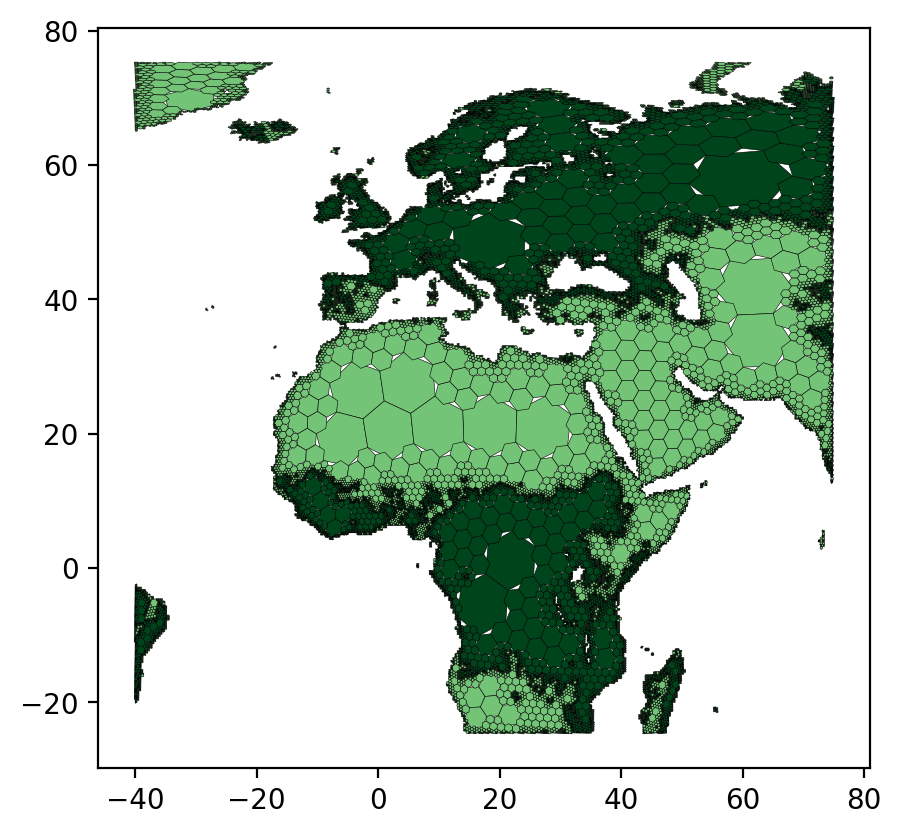

In [8]:
from h3ronpy.raster import raster_to_dataframe

print("conversion start")
vegetation_h3_df = raster_to_dataframe(
    vegetation, src.transform, h3_res, nodata_value=vegetation_nodata_value, compacted=True, geo=True)
print("conversion done")

print("plotting ... this may take a bit")
vegetation_h3_df.plot(column="value", linewidth=0.2,
                      edgecolor="black", **vegetation_plot_args)
pyplot.show()


<AxesSubplot:>

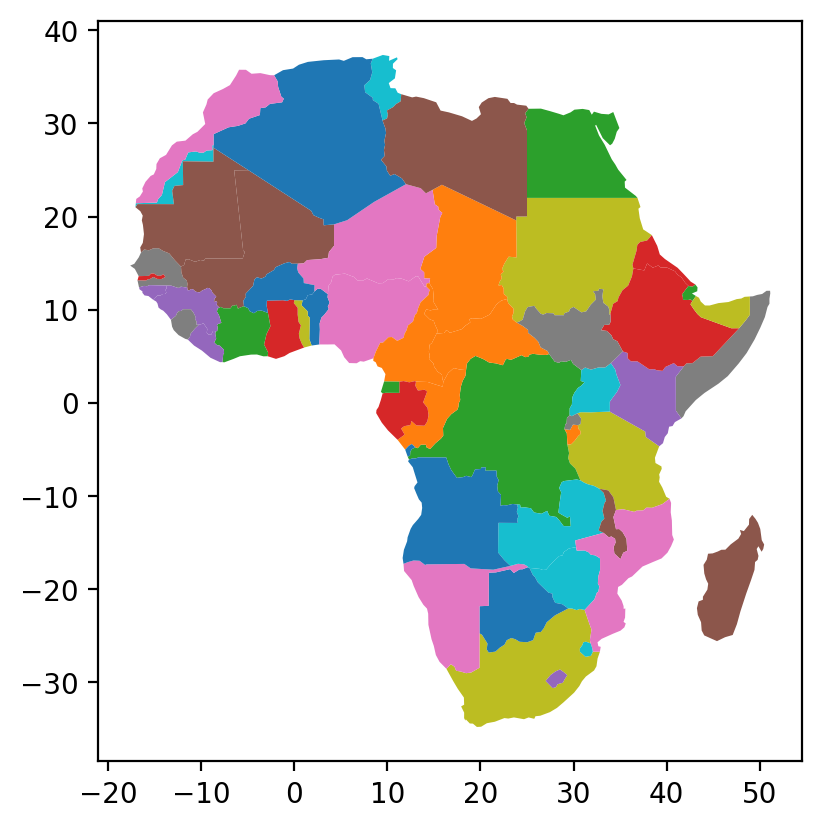

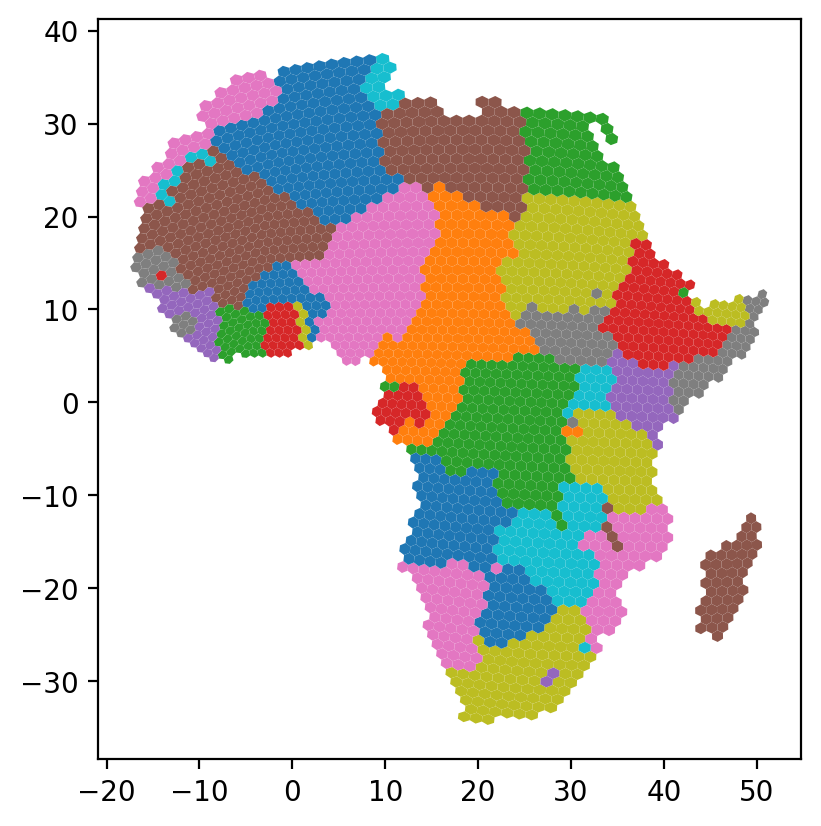

In [9]:
import geopandas as gpd
from h3ronpy import vector, util

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
africa = world[world["continent"] == "Africa"]
africa.plot(column="name")

# convert to h3 cells and build a new geodataframe
gdf = util.h3index_column_to_geodataframe(vector.geodataframe_to_h3(africa, 3))
gdf.plot(column="name")


<AxesSubplot:>

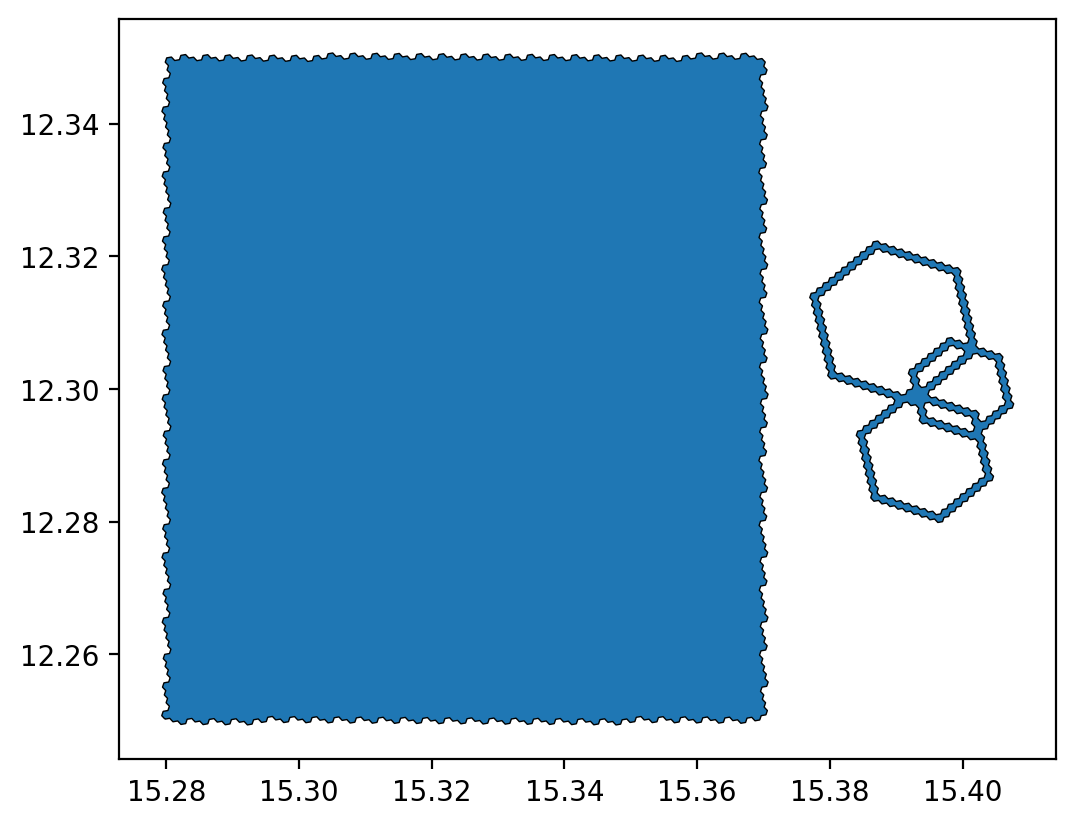

In [10]:
from h3ronpy import Polygon

squares_and_rings = np.concatenate([
    h3.hex_ring(h3.geo_to_h3(12.3, 15.4, 10), 6),
    h3.hex_ring(h3.geo_to_h3(12.31, 15.39, 10), 10),
    h3.hex_ring(h3.geo_to_h3(12.29, 15.395, 10), 8),
    h3.polyfill_polygon([
        (12.25, 15.28),
        (12.25, 15.37),
        (12.35, 15.37),
        (12.35, 15.28),
        (12.25, 15.28)
    ], 10, lnglat_order=False)
])
sqr_geoms = Polygon.from_h3indexes(
    squares_and_rings)  # returns a list of polygons
gpd.GeoDataFrame({}, geometry=sqr_geoms).plot(edgecolor="black", linewidth=0.5)


<AxesSubplot:>

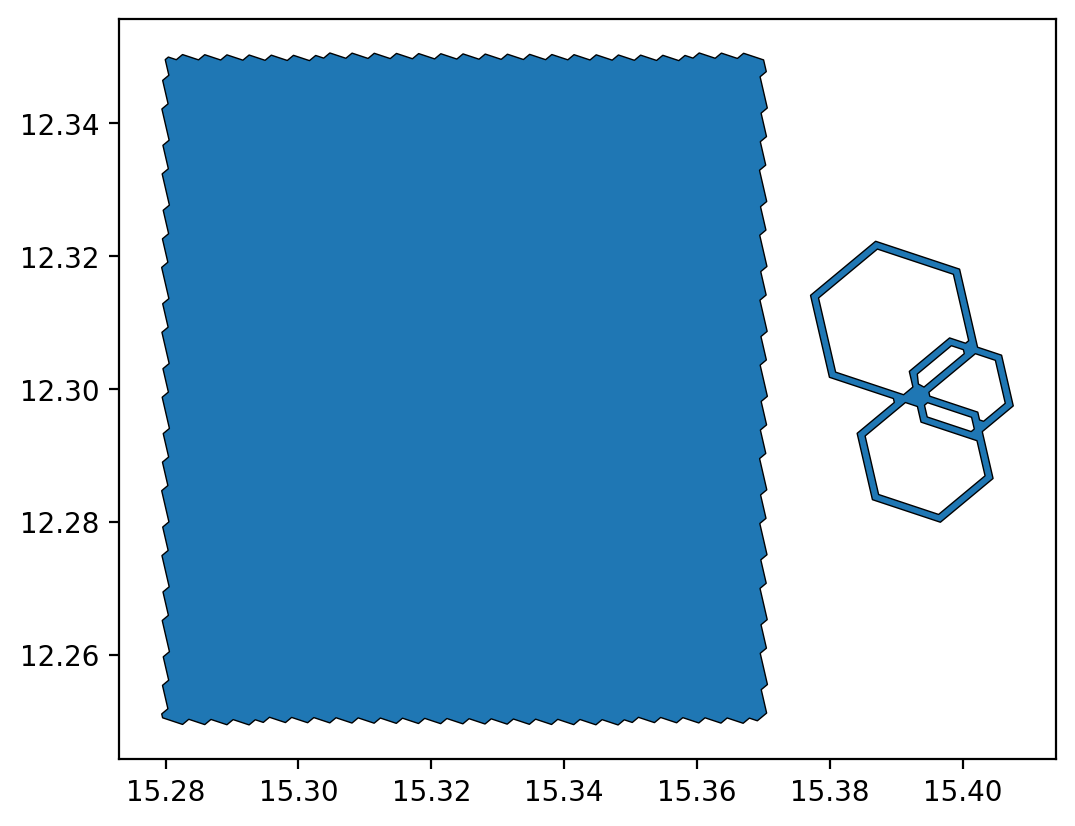

In [11]:
sqr_smoothed = Polygon.from_h3indexes(squares_and_rings, smoothen=True)
gpd.GeoDataFrame({}, geometry=sqr_smoothed).plot(
    edgecolor="black", linewidth=0.5)


<AxesSubplot:>

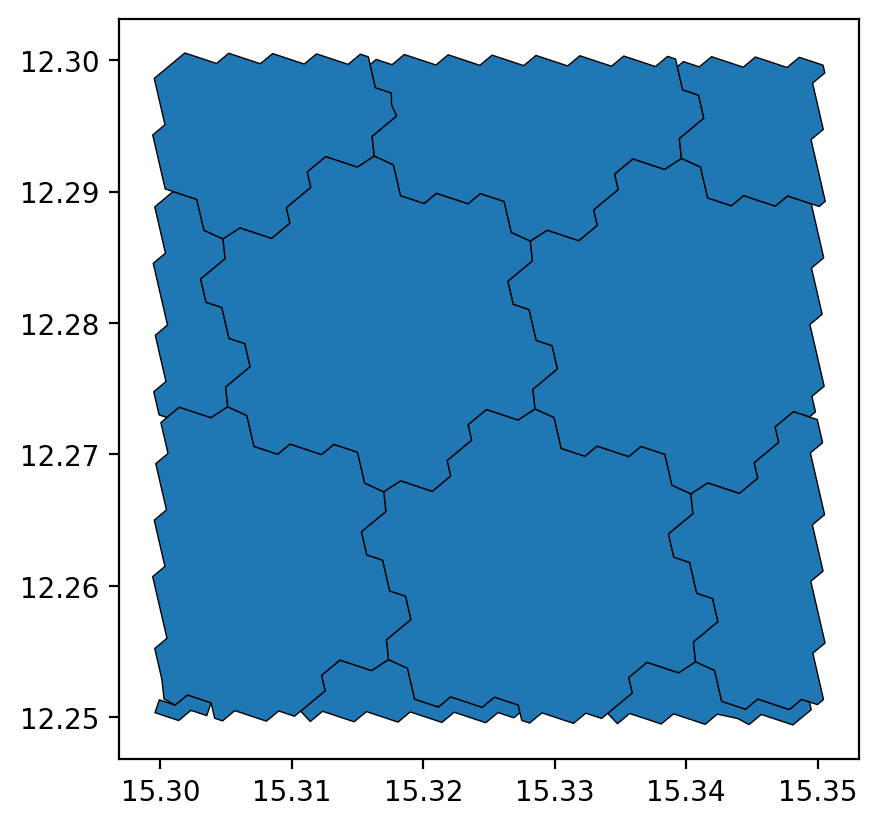

In [12]:
box_indexes = h3.polyfill_polygon([
    (12.25, 15.30),
    (12.25, 15.35),
    (12.30, 15.35),
    (12.30, 15.30),
    (12.25, 15.30)
], 10)

# aling the geometries to h3 resolution 2 where complete edges touch. This reduced the number of vertices
# a fair amount
box_aligned_geoms = Polygon.from_h3indexes_aligned(
    box_indexes, 7, smoothen=True)
gpd.GeoDataFrame({}, geometry=box_aligned_geoms).plot(
    edgecolor="black", linewidth=0.5)
